In [ ]:
# %load ../loader.py
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext dotenv
%dotenv

import os
import sys
from datetime import date, datetime
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from polars import col

# Make nicer matplotlib plots by default
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["text.usetex"] = False

ROOTDIR = Path(".") / ".." / ".."
if str(ROOTDIR) not in sys.path:
    sys.path.insert(0, str(ROOTDIR))

COREDIR = ROOTDIR / ".." / "cgoudetcore"
if str(COREDIR) not in sys.path:
    sys.path.insert(0, str(COREDIR))

from src.duck import read_sql

In [ ]:
from src.metrics import gini_index

In [ ]:
date.today()

datetime.date(2024, 10, 30)

In [ ]:
rq = f"""
select distinct(profession) 
from beneficiaire
where profession is not null
"""
profs = (
    pl.read_parquet(
        "../../data/03_primary/dim_beneficiaire.parquet", columns=["profession"]
    )
    .filter(col("profession").is_not_null())
    .unique()
)
print("Toutes les professsions")
sorted(sorted(profs["profession"]))

Toutes les professsions


['acteur du système de santé caractérisé par un rôle',
 'ambulancier',
 'assistant dentaire',
 'assistant social',
 'audio-prothésiste',
 'chiropracteur',
 'chirurgien-dentiste',
 'diététicien',
 'epithésiste',
 'ergothérapeute',
 'infirmier',
 'manipulateur erm',
 'masseur-kinésithérapeute',
 'médecin',
 'oculariste',
 'opticien-lunetier',
 'orthophoniste',
 'orthoprothésiste',
 'orthoptiste',
 'orthopédiste-orthésiste',
 'ostéopathe',
 'pharmacien',
 'physicien médical',
 'podo-orthésiste',
 "prothésiste et orthésiste pour l'appareillage des personnes handicapées",
 'préparateur en pharmacie et préparateur en pharmacie hospitalière',
 'psychologue',
 'psychomotricien',
 'psychothérapeute',
 'pédicure-podologue',
 'sage-femme',
 'technicien de laboratoire',
 'vétérinaire']

In [ ]:
profession = "pharmacien"

# Représentativité de la profession

In [ ]:
ben = pl.read_parquet("../../data/01_raw/beneficiaire.parquet")
ben["verified_id"].mean()

0.7682490560882623

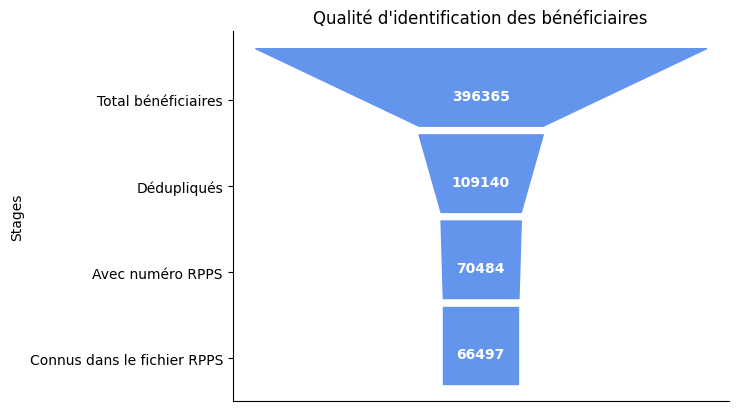

In [ ]:
ben = pl.read_parquet("../../data/01_raw/beneficiaire.parquet").filter(
    col("profession") == profession
)
uniques = ben.select(pl.col("efd_id").unique()).shape[0]
origins = (
    ben.filter(pl.col("origin_account").is_null())
    .select(pl.col("efd_id").unique())
    .shape[0]
)
non_identified = (
    ben.filter(pl.col("origin_account").is_null() & pl.col("rpps").is_null())
    .select(pl.col("efd_id").unique())
    .shape[0]
)
identified = (
    ben.filter(pl.col("origin_account").is_null() & pl.col("verified_id"))
    .select(pl.col("efd_id").unique())
    .shape[0]
)
from src.visualisation import funnel_chart

labels = [
    "Total bénéficiaires",
    "Dédupliqués",
    "Avec numéro RPPS",
    "Connus dans le fichier RPPS",
]
values = [uniques, origins, origins - non_identified, identified]

fig, ax = plt.subplots()
funnel_chart(labels, values, ax=ax)
ax.set_title("Qualité d'identification des bénéficiaires")
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
rpps = (
    pl.read_parquet("../../data/01_raw/rpps.parquet")
    .filter(col("profession") == profession)
    .unique("origin_account")
)

num_rpps = rpps.shape[0]
print(f"Nombre dans le rpps : {num_rpps}")
print(f"Représentativité dans transparence santé : {np.round(origins/num_rpps*100,1)}%")

Nombre dans le rpps : 95909
Représentativité dans transparence santé : 113.8%


# Analyse des liens financiers

In [ ]:
profession

'pharmacien'

In [ ]:
%%time
from src.pipeline.common import declarations

liens = declarations().filter(col("profession") == profession)
liens.shape

2024-10-30 19:16:36 [info     ] raw_liens                      montant=-786888910 n_benef=1300931 n_entreprise=2383
CPU times: user 1.73 s, sys: 711 ms, total: 2.44 s
Wall time: 704 ms


(820885, 9)

In [ ]:
sorted(liens.columns)

['ben_categorie',
 'efd_id',
 'entreprise_id',
 'lien',
 'montant',
 'montant_cat',
 'montant_masque',
 'motif',
 'profession']

In [ ]:
montant_total = liens["montant"].sum()
f"{round(montant_total / 1e6,2)} millions dépensés par les entreprises pour la profession {profession}"

'82.82 millions dépensés par les entreprises pour la profession pharmacien'

In [ ]:
liens.filter(col("lien") == "Convention").select(
    (col("montant_masque").mean() * 100).round(1).alias("pct_masque"),
    col("montant_masque").sum().alias("n_conv_masque"),
    (col("montant").sum() / 1e6).alias("montant_millions"),
)

shape: (1, 3)
┌────────────┬───────────────┬──────────────────┐
│ pct_masque ┆ n_conv_masque ┆ montant_millions │
│ ---        ┆ ---           ┆ ---              │
│ f64        ┆ i32           ┆ f64              │
╞════════════╪═══════════════╪══════════════════╡
│ 72.0       ┆ 103754        ┆ 9.936964         │
└────────────┴───────────────┴──────────────────┘

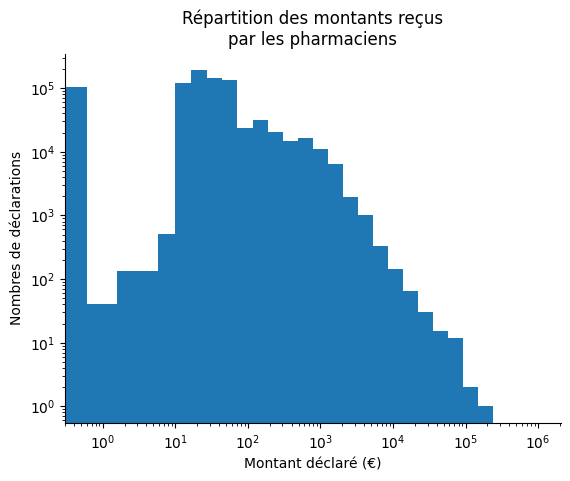

In [ ]:
fig, ax = plt.subplots()
m = np.ceil(np.log10(liens["montant"].max()))
bins = np.float_power(10, np.linspace(0, m, int(m * 5))) - 1
ax.hist(liens.select("montant"), bins=bins)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Montant déclaré (€)")
ax.set_ylabel("Nombres de déclarations")
ax.set_title(f"Répartition des montants reçus\npar les {profession}s")
fig.savefig("dum.png", bbox_inches="tight")

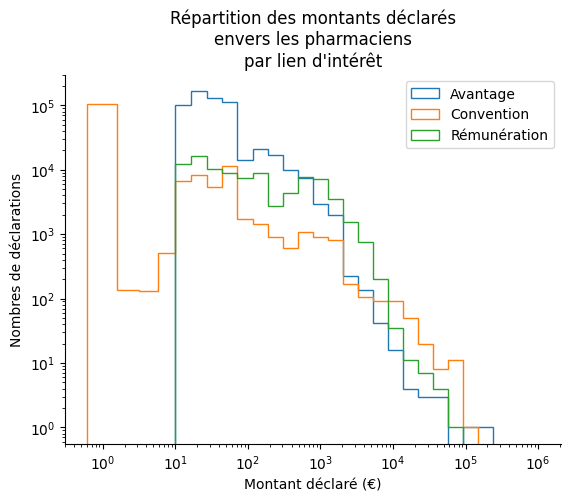

In [ ]:
fig, ax = plt.subplots()
for lien_interet in sorted(liens["lien"].unique()):
    tmp = liens.filter(col("lien") == lien_interet)
    ax.hist(
        tmp["montant"].clip(lower_bound=1),
        bins=bins,
        label=lien_interet,
        histtype="step",
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Montant déclaré (€)")
ax.set_ylabel("Nombres de déclarations")
ax.set_title(
    f"Répartition des montants déclarés\nenvers les {profession}s\npar lien d'intérêt"
)
plt.legend()

fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
liens.group_by(col("motif").fill_null("NULL")).agg(col("montant").sum()).with_columns(
    col("montant") / montant_total * 100
).sort("montant", descending=True)

shape: (5, 2)
┌───────────────┬───────────┐
│ motif         ┆ montant   │
│ ---           ┆ ---       │
│ str           ┆ f64       │
╞═══════════════╪═══════════╡
│ evenement     ┆ 75.430117 │
│ consultance   ┆ 10.779839 │
│ don et bourse ┆ 8.986267  │
│ Autre         ┆ 3.836463  │
│ R&D           ┆ 0.967314  │
└───────────────┴───────────┘

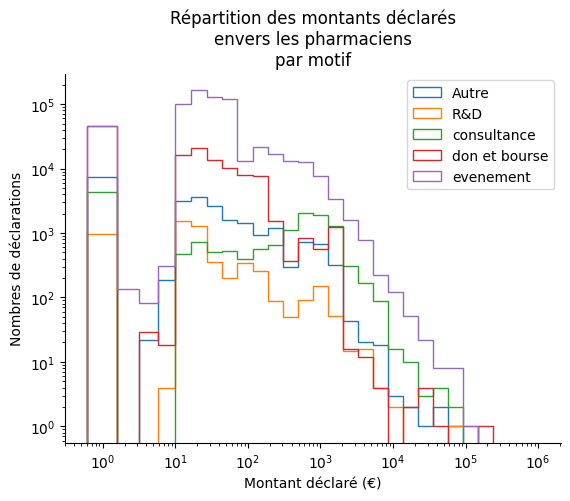

In [ ]:
fig, ax = plt.subplots()

for motif in sorted(liens["motif"].unique()):
    tmp = liens.filter(col("motif") == motif)
    ax.hist(tmp["montant"].clip(lower_bound=1), bins=bins, label=motif, histtype="step")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Montant déclaré (€)")
ax.set_ylabel("Nombres de déclarations")
ax.set_title(f"Répartition des montants déclarés\nenvers les {profession}s\npar motif")
plt.legend()

fig.savefig("dum.png", bbox_inches="tight")

# Etude bénéficiaires

In [ ]:
dim_beneficiaire = (
    pl.read_parquet("../../data/03_primary/dim_beneficiaire.parquet")
    .filter((col("profession") == profession) & col("montant_total").is_not_null())
    .sort("montant_total", descending=True)
)
print(dim_beneficiaire.shape)
dim_beneficiaire.head().select("efd_id", "nom", "prenom", "montant_total")

(109011, 27)


shape: (5, 4)
┌──────────────────────┬──────────────┬─────────────┬───────────────┐
│ efd_id               ┆ nom          ┆ prenom      ┆ montant_total │
│ ---                  ┆ ---          ┆ ---         ┆ ---           │
│ u64                  ┆ str          ┆ str         ┆ i32           │
╞══════════════════════╪══════════════╪═════════════╪═══════════════╡
│ 10850400742657180456 ┆ CARDOT       ┆ Jean Michel ┆ 490132        │
│ 12719240031861277714 ┆ RIGAUD       ┆ Jean Paul   ┆ 282787        │
│ 10906213169593964577 ┆ PEYTAVIN     ┆ Gilles      ┆ 255717        │
│ 11400853783191531715 ┆ HUBER HUSSON ┆ Axelle      ┆ 239182        │
│ 10266075414431849145 ┆ VAN ASSEL    ┆ Thierry     ┆ 237580        │
└──────────────────────┴──────────────┴─────────────┴───────────────┘

In [ ]:
large_benef = dim_beneficiaire.filter(col("montant_total") > 999)
pct_large = large_benef["montant_total"].sum() / dim_beneficiaire["montant_total"].sum()
prop_large = large_benef.shape[0] / dim_beneficiaire.shape[0]
print("Proportion représentée par les bénéficiaires de plus de 1 000€:")
print(f"{round(pct_large*100,2)}% des montants")
print(f"{round(prop_large*100,2)}% des bénéficiaires")

Proportion représentée par les bénéficiaires de plus de 1 000€:
83.7% des montants
8.68% des bénéficiaires


In [ ]:
ineg = gini_index(dim_beneficiaire["montant_total"])
f"Niveau d'inégalité entre les bénéficiaires : {round(ineg*100,1)}%"

"Niveau d'inégalité entre les bénéficiaires : 89.1%"

In [ ]:
large_benef = dim_beneficiaire.filter(col("montant_total") > 9999)
pct_large = large_benef["montant_total"].sum() / dim_beneficiaire["montant_total"].sum()
prop_large = large_benef.shape[0] / dim_beneficiaire.shape[0]
print("Proportion représentée par les bénéficiaires de plus de 10k€:")
print(f"{round(pct_large*100,2)}% des montants")
print(f"{round(prop_large*100,2)}% des bénéficiaires")

Proportion représentée par les bénéficiaires de plus de 10k€:
56.87% des montants
1.41% des bénéficiaires


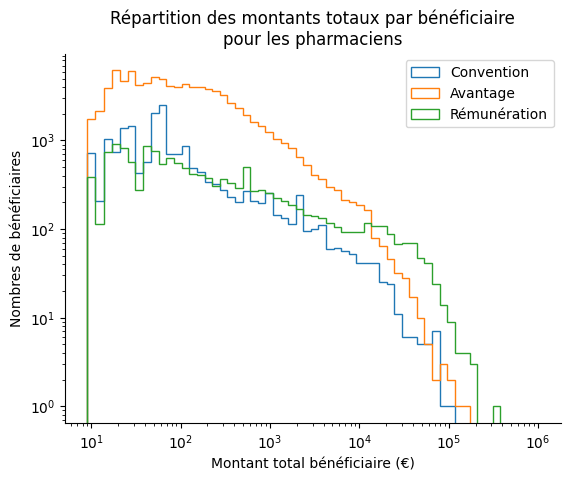

In [ ]:
fig, ax = plt.subplots()
m = np.ceil(np.log10(dim_beneficiaire["montant_total"].max()))
bins = np.float_power(10, np.linspace(1, m, int(m * 10))) - 1
for lien_interet in liens["lien"].unique():
    ax.hist(
        dim_beneficiaire.select(col("montant_total") * col("pct_lien_" + lien_interet)),
        bins=bins,
        label=lien_interet,
        histtype="step",
    )
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Montant total bénéficiaire (€)")
ax.set_ylabel("Nombres de bénéficiaires")
ax.set_title(
    f"Répartition des montants totaux par bénéficiaire\npour les {profession}s"
)
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
above_10k = dim_beneficiaire.filter(col("montant_total") > 10_000)
pct = round(len(above_10k) / len(dim_beneficiaire) * 100, 1)
montant = above_10k["montant_total"].sum() / 1e6
montant_pct = round(montant * 1e6 / dim_beneficiaire["montant_total"].sum() * 100, 1)
print(
    f"Nombre de bénéficaire recevant plus de 10k€ : {len(above_10k)} ({pct}%). Montant total : {round(montant)}me ({montant_pct}%)"
)

above_1k = dim_beneficiaire.filter(col("montant_total") > 1_000)
montant = round(
    above_1k["montant_total"].sum() / dim_beneficiaire["montant_total"].sum() * 100, 1
)
pct = round(len(above_1k) / len(dim_beneficiaire) * 100, 1)
montant = above_1k["montant_total"].sum() / 1e6
montant_pct = round(montant * 1e6 / dim_beneficiaire["montant_total"].sum() * 100, 1)
print(
    f"Nombre de bénéficaire recevant plus de 1k€ : {len(above_1k)} ({pct}%). Montant total : {round(montant)}me ({montant_pct}%)"
)

Nombre de bénéficaire recevant plus de 10k€ : 1534 (1.4%). Montant total : 47me (56.9%)
Nombre de bénéficaire recevant plus de 1k€ : 9445 (8.7%). Montant total : 69me (83.7%)


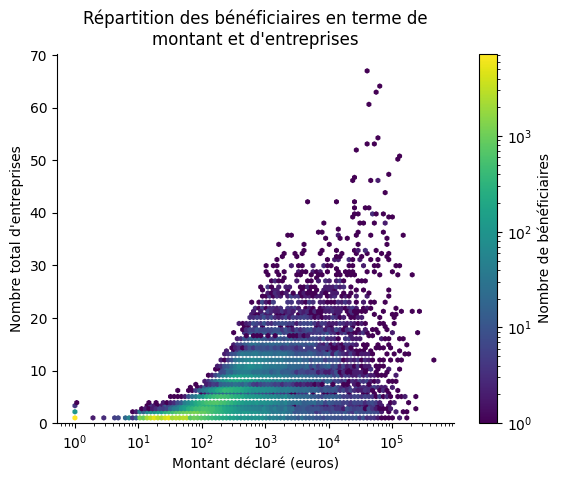

In [ ]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    dim_beneficiaire["montant_total"] + 1,
    dim_beneficiaire["n_companies"],
    xscale="log",
    #  yscale="log",
    bins="log",
)
ax.set_xlabel("Montant déclaré (euros)")
ax.set_ylabel("Nombre total d'entreprises")
ax.set_ylim(0, None)
cb = fig.colorbar(hb, ax=ax)
cb.set_label("Nombre de bénéficiaires")
ax.set_title("Répartition des bénéficiaires en terme de\nmontant et d'entreprises")
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
to_show = dim_beneficiaire.filter((col("n_companies") > 3) & (col("montant_total") > 0))
hb = ax.hexbin(
    to_show["montant_total"],
    to_show["gini"],
    xscale="log",
    #  yscale="log",
    bins="log",
)
ax.set_xlabel("Montant déclaré (euros)")
ax.set_ylabel("Score de gini")
ax.set_ylim(0, 1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label("Nombre de bénéficiaires")
ax.set_title("Répartition des bénéficiaires en terme de\nmontant et score de gini")
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
top5 = dim_beneficiaire.head(5)
top5.select(
    "nom",
    "prenom",
    "montant_total",
    "n_companies",
    "gini",
    "pct_motif_Autre",
    "pct_motif_R&D",
    "pct_motif_consultance",
    "pct_motif_don_et_bourse",
    "pct_motif_evenement",
    "pct_lien_Avantage",
    "pct_lien_Convention",
    "pct_lien_Rémunération",
)

shape: (5, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ nom       ┆ prenom    ┆ montant_t ┆ n_compani ┆ … ┆ pct_motif ┆ pct_lien_ ┆ pct_lien_ ┆ pct_lien │
│ ---       ┆ ---       ┆ otal      ┆ es        ┆   ┆ _evenemen ┆ Avantage  ┆ Conventio ┆ _Rémunér │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ t         ┆ ---       ┆ n         ┆ ation    │
│           ┆           ┆ i32       ┆ u32       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CARDOT    ┆ Jean      ┆ 490132    ┆ 12        ┆ … ┆ 0.1237    ┆ 0.0853    ┆ 0.186     ┆ 0.7287   │
│           ┆ Michel    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ RIGAUD    ┆ Jean Paul ┆ 282787    ┆ 21        ┆ … ┆ 0.9992    ┆ 0.005     ┆ 0.2643    ┆ 0.7306   │
│ PEYTAVIN  ┆ Gilles    ┆ 255717    ┆ 17        ┆ … ┆ 0.5324    ┆ 0.2641    ┆ 0.2824    ┆ 0.4535   │
│ HUBER     ┆ Axelle    ┆ 239182    ┆ 3         ┆ … ┆ 1.0       ┆ 0.0002    ┆ 0.2901    ┆ 0.7098   │
│ HUSSON    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ VAN ASSEL ┆ Thierry   ┆ 237580    ┆ 5         ┆ … ┆ 0.9996    ┆ 0.001     ┆ 0.2795    ┆ 0.7196   │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
fig, ax = plt.subplots()
m = np.ceil(np.log10(top5["montant_total"].max()))
bins = np.float_power(10, np.linspace(1, m, int(m * 10))) - 1

opts = {"histtype": "step", "bins": bins}
for efd_id in top5["efd_id"]:
    tmp = liens.filter(col("efd_id") == efd_id)
    name = list(
        top5.filter(col("efd_id") == efd_id)
        .select(
            col("nom")
            + " "
            + col("prenom")
            + "; "
            + (col("montant_total") / 1e3).round().cast(pl.Int32).cast(pl.String)
            + "ke"
        )
        .head(1)["nom"]
    )[0]
    ax.hist(tmp["montant"], label=name, **opts)
fig.legend()
ax.set_xscale("log")
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
liens.columns

['ben_categorie',
 'profession',
 'efd_id',
 'entreprise_id',
 'montant_masque',
 'montant',
 'lien',
 'montant_cat',
 'motif']

In [ ]:
liens.join(top5.select("efd_id", "nom", "prenom"), on="efd_id").with_columns(
    col("nom") + " " + col("prenom"),
    col("montant")/1e3
).pivot(index="nom", on="motif", values='montant', aggregate_function="sum")

shape: (5, 6)
┌─────────────────────┬───────────┬─────────────┬────────┬───────┬───────────────┐
│ nom                 ┆ evenement ┆ consultance ┆ R&D    ┆ Autre ┆ don et bourse │
│ ---                 ┆ ---       ┆ ---         ┆ ---    ┆ ---   ┆ ---           │
│ str                 ┆ f64       ┆ f64         ┆ f64    ┆ f64   ┆ f64           │
╞═════════════════════╪═══════════╪═════════════╪════════╪═══════╪═══════════════╡
│ RIGAUD Jean Paul    ┆ 282.572   ┆ null        ┆ null   ┆ 0.215 ┆ 0.0           │
│ PEYTAVIN Gilles     ┆ 136.155   ┆ 112.518     ┆ null   ┆ 5.007 ┆ 2.037         │
│ CARDOT Jean Michel  ┆ 60.63     ┆ 415.846     ┆ 13.656 ┆ null  ┆ null          │
│ VAN ASSEL Thierry   ┆ 237.48    ┆ null        ┆ null   ┆ null  ┆ 0.1           │
│ HUBER HUSSON Axelle ┆ 239.182   ┆ null        ┆ null   ┆ null  ┆ null          │
└─────────────────────┴───────────┴─────────────┴────────┴───────┴───────────────┘

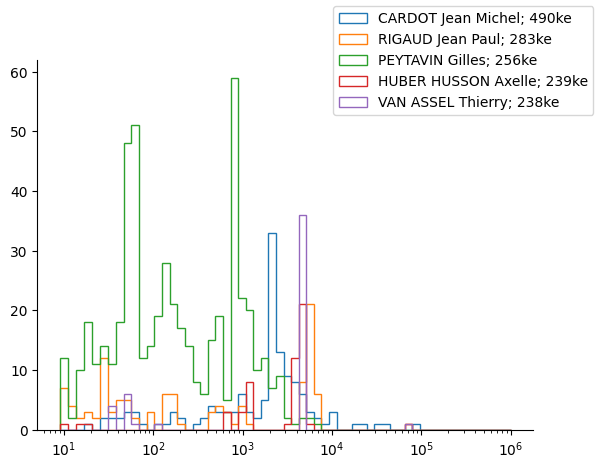

In [ ]:
fig, ax = plt.subplots()
m = np.ceil(np.log10(top5["montant_total"].max()))
bins = np.float_power(10, np.linspace(1, m, int(m * 10))) - 1

opts = {"histtype": "step", "bins": bins}
for efd_id in top5["efd_id"]:
    tmp = liens.filter(col("efd_id") == efd_id)
    name = list(
        top5.filter(col("efd_id") == efd_id)
        .select(
            col("nom")
            + " "
            + col("prenom")
            + "; "
            + (col("montant_total") / 1e3).round().cast(pl.Int32).cast(pl.String)
            + "ke"
        )
        .head(1)["nom"]
    )[0]
    ax.hist(tmp["montant"], label=name, **opts)
fig.legend()
ax.set_xscale("log")
fig.savefig("dum.png", bbox_inches="tight")

# Etude des entreprises

In [ ]:
n_companies = liens.select(col("entreprise_id").unique()).shape[0]
f"Nombre d'entreprises : {n_companies}"

"Nombre d'entreprises : 898"

In [ ]:
from src.pipeline.dim_entreprise import dim_entreprise

dim_entreprise = dim_entreprise(liens).sort("montant_total", descending=True)
print("n_entreprises", len(dim_entreprise))

2024-10-30 19:16:39 [info     ] dim_entreprises                columns=['entreprise_id', 'gini', 'montant_total', 'n_beneficiaires', 'n_declarations', 'nb_mere_id', 'nb_pays', 'nb_raison_sociale', 'nb_secteur_activite', 'nb_siren', 'pays', 'pct_lien_Avantage', 'pct_lien_Convention', 'pct_lien_Rémunération', 'pct_motif_Autre', 'pct_motif_R&D', 'pct_motif_consultance', 'pct_motif_don_et_bourse', 'pct_motif_evenement', 'raison_sociale', 'rate_masked', 'secteur_activite', 'siren'] shape=(898, 23)
n_entreprises 898


In [ ]:
top5 = dim_entreprise.head().select(
    "entreprise_id", "raison_sociale", col("montant_total") / 1e6
)
top5_pct = round(top5["montant_total"].sum() / montant_total * 1e6 * 100, 1)
print(f"Les top 5 entreprises représentent {top5_pct}% du montant total dépensé.")
top5

Les top 5 entreprises représentent 42.4% du montant total dépensé.


shape: (5, 3)
┌───────────────┬───────────────────────┬───────────────┐
│ entreprise_id ┆ raison_sociale        ┆ montant_total │
│ ---           ┆ ---                   ┆ ---           │
│ i32           ┆ str                   ┆ f64           │
╞═══════════════╪═══════════════════════╪═══════════════╡
│ 79            ┆ TEVA SANTE SAS        ┆ 11.639994     │
│ 34            ┆ SANDOZ                ┆ 10.011756     │
│ 89            ┆ SANOFI AVENTIS FRANCE ┆ 5.543392      │
│ 132           ┆ BIOGARAN              ┆ 4.663849      │
│ 339           ┆ ROCHE SAS             ┆ 3.285275      │
└───────────────┴───────────────────────┴───────────────┘

In [ ]:
top_pct = 10
n_largest = round(len(dim_entreprise) * top_pct / 100)
prop = (
    liens.filter(
        col("entreprise_id").is_in(dim_entreprise.head(n_largest)["entreprise_id"])
    )["montant"].sum()
    / montant_total
)
f"Proportions des {top_pct}% ({n_largest}) plus grosses entreprises : {round(prop*100,1)}%"

'Proportions des 10% (90) plus grosses entreprises : 89.8%'

In [ ]:
ineg = gini_index(dim_entreprise["montant_total"])
f"Niveau d'inégalité entre les entreprises : {round(ineg*100,1)}%"

"Niveau d'inégalité entre les entreprises : 93.0%"

In [ ]:
no_montant = len(dim_entreprise.filter(col("montant_total") == 0))
f"{no_montant} entreprises n'ont montant documenté"

"33 entreprises n'ont montant documenté"

In [ ]:
montant_rate = (
    liens.filter(col("lien") == "Convention")
    .group_by("entreprise_id")
    .agg((col("montant") > 0).cast(pl.Int8).mean())
    .filter(col("montant") <= 0.2)
)
pct_ent = round(len(montant_rate) * 100 / len(dim_entreprise), 1)
f"{len(montant_rate)} entreprises ({pct_ent}%) ont moins de 20% de conventions avec un montant"

'205 entreprises (22.8%) ont moins de 20% de conventions avec un montant'

In [ ]:
quantiles = [0.2, 0.8, 0.9, 0.95, 0.99]
for q in quantiles:
    limit = dim_entreprise["montant_total"].quantile(q)
    over = (
        dim_entreprise.filter(col("montant_total") >= limit)["montant_total"].sum()
        / montant_total
    )

    print(q * 100, limit, round(over * 100, 1), "%")

20.0 125.0 100.0 %
80.0 32018.0 96.4 %
90.0 112034.0 89.9 %
95.0 224761.0 81.5 %
99.0 1562034.0 54.2 %


In [ ]:
dim_entreprise.filter(col("n_beneficiaires") == 1).shape

(173, 23)

In [ ]:
dependencies = (
    dim_beneficiaire.with_columns(
        influence_level=pl.when(col("pct_large_ent") > 0.9)
        .then(pl.lit("Influence totale (>90%)"))
        .when(col("pct_large_ent") < 0.1)
        .then(pl.lit("Influence nulle (<10%)"))
        .otherwise(pl.lit("Influence partielle"))
    )["influence_level"]
    .value_counts()
    .sort("influence_level")
)
print(dependencies)
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 11)
ax.barh(
    dependencies["influence_level"],
    dependencies["count"] / dependencies["count"].sum() * 100,
)
ax.set_xlabel(f"Taux de {profession}s (%)")
ax.set_ylabel("Niveau d'influence")
ax.set_title(
    f"Répartition des taux de dépendances des {profession}s\nau top 5% des entreprises"
)
fig.savefig("dum.png", bbox_inches="tight")

shape: (3, 2)
┌─────────────────────────┬───────┐
│ influence_level         ┆ count │
│ ---                     ┆ ---   │
│ str                     ┆ u32   │
╞═════════════════════════╪═══════╡
│ Influence nulle (<10%)  ┆ 54053 │
│ Influence partielle     ┆ 34867 │
│ Influence totale (>90%) ┆ 20091 │
└─────────────────────────┴───────┘


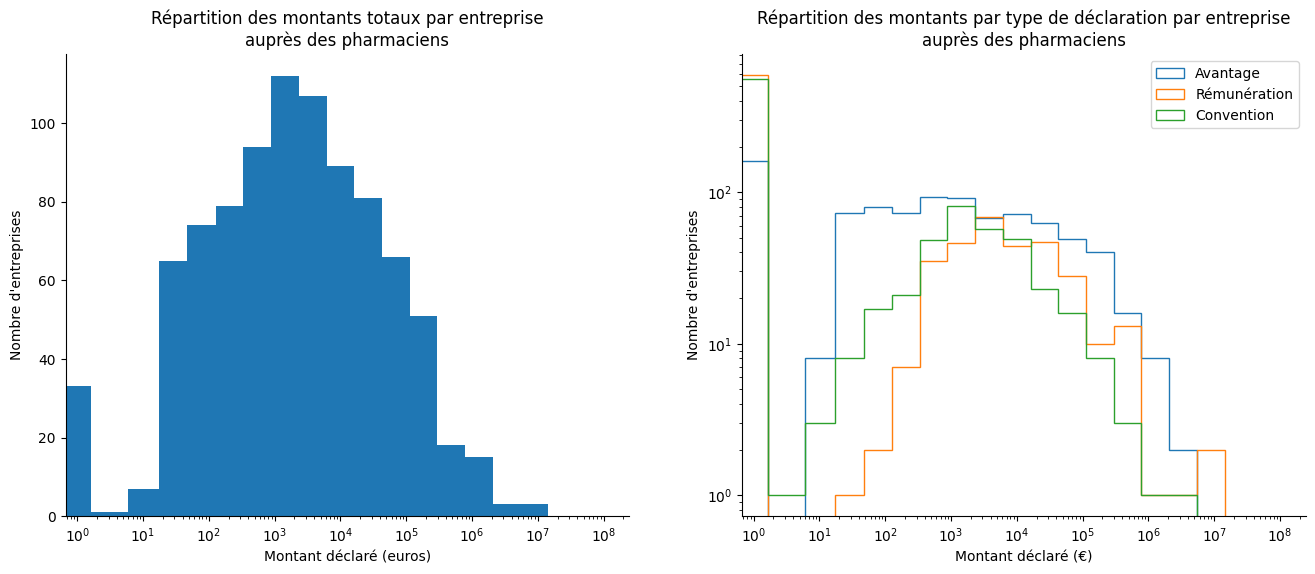

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
bins = np.float_power(10, np.linspace(0, 8, 20)) - 1

axs[0].hist(dim_entreprise.select("montant_total"), bins=bins)
axs[0].set_xscale("log")
axs[0].set_xlabel("Montant déclaré (euros)")
axs[0].set_ylabel("Nombre d'entreprises")
axs[0].set_title(f"Répartition des avantages auprès des {profession}\npar entreprise")
axs[0].set_title(
    f"Répartition des montants totaux par entreprise\nauprès des {profession}s"
)

for lien_interet in liens["lien"].unique():
    axs[1].hist(
        dim_entreprise.select(
            col("montant_total") * col("pct_lien_" + lien_interet).fill_null(0)
        ),
        bins=bins,
        label=lien_interet,
        histtype="step",
    )

plt.legend()
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Montant déclaré (€)")
axs[1].set_ylabel("Nombre d'entreprises")
axs[1].set_title(
    f"Répartition des montants par type de déclaration par entreprise\nauprès des {profession}s"
)
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
bins = np.float_power(10, np.linspace(1, 5, 35)) - 1
ax.hist(dim_entreprise.select("n_beneficiaires"), bins=bins)
ax.set_xscale("log")
ax.set_xlabel("Nombre de bénéficiaires")
ax.set_ylabel("Nombre d'entreprises")
ax.set_title(profession)
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 26)
ax.hist(dim_entreprise.select("rate_masked"), bins=bins)
ax.set_xlabel("Taux de masquage")
ax.set_ylabel("Nombre d'entreprises")
ax.set_title(profession)
print(
    "Entreprises avec +80% de masquage",
    dim_entreprise.filter(col("rate_masked") > 0.8).shape[0],
)
fig.savefig("dum.png", bbox_inches="tight")

Entreprises avec +80% de masquage 204


In [ ]:
fig, ax = plt.subplots()
for montant in [10, 100, 1000]:
    ax.plot([montant, 1e6], [1, 1e6 / montant], color="lightgrey")
ax.scatter(
    dim_entreprise["montant_total"], dim_entreprise["n_beneficiaires"], alpha=0.3
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Montant des avantages (euros)")
ax.set_ylabel("Nombre total de bénéficiaires")
ax.set_title(
    "Relation entre le montant dépensé et le nombre de bénéficiaires\npour les entreprises déclarantes"
)
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
sorted(dim_entreprise.columns)

['entreprise_id',
 'gini',
 'montant_total',
 'n_beneficiaires',
 'n_declarations',
 'nb_mere_id',
 'nb_pays',
 'nb_raison_sociale',
 'nb_secteur_activite',
 'nb_siren',
 'pays',
 'pct_lien_Avantage',
 'pct_lien_Convention',
 'pct_lien_Rémunération',
 'pct_motif_Autre',
 'pct_motif_R&D',
 'pct_motif_consultance',
 'pct_motif_don_et_bourse',
 'pct_motif_evenement',
 'raison_sociale',
 'rate_masked',
 'secteur_activite',
 'siren']

In [ ]:
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 51)
ax.hist(dim_entreprise.filter(col("n_declarations") > 1).select("gini"), bins=bins)
ax.set_xlabel("Indice de Gini")
ax.set_ylabel("Nombre d'entreprises")
ax.set_title(f"Répartition des avantages auprès des {profession}\npar entreprise");

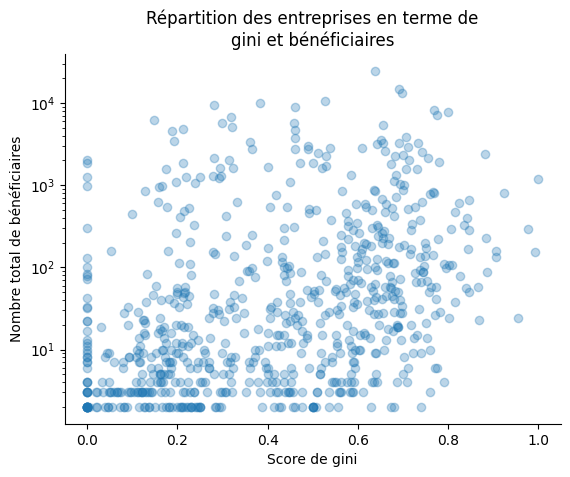

In [ ]:
to_show = dim_entreprise.filter(col("n_beneficiaires") > 1)
fig, ax = plt.subplots()
ax.scatter(to_show["gini"], to_show["n_beneficiaires"], alpha=0.3)
ax.set_yscale("log")
ax.set_xlabel("Score de gini")
ax.set_ylabel("Nombre total de bénéficiaires")
ax.set_title("Répartition des entreprises en terme de\ngini et bénéficiaires")
fig.savefig("dum.png", bbox_inches="tight")

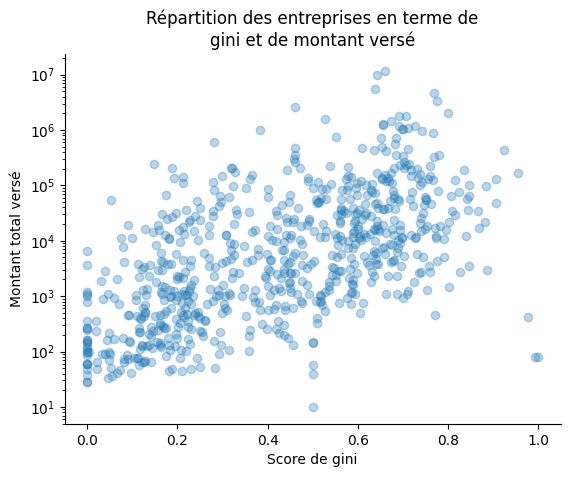

In [ ]:
to_show = dim_entreprise.filter(col("n_beneficiaires") > 1)
fig, ax = plt.subplots()
ax.scatter(to_show["gini"], to_show["montant_total"], alpha=0.3)
ax.set_yscale("log")
ax.set_xlabel("Score de gini")
ax.set_ylabel("Montant total versé")
ax.set_title("Répartition des entreprises en terme de\ngini et de montant versé")
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
dim_entreprise.filter(
    (col("montant_total") < 20000)
    & (col("n_beneficiaires") > 30)
    & (col("montant_total") > 6000)
    & (col("gini") > 0.3)
    & (col("rate_masked") < 0.5)
).sort("rate_masked")

shape: (12, 23)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ entrepris ┆ raison_so ┆ secteur_a ┆ siren     ┆ … ┆ pct_motif ┆ pct_lien_ ┆ pct_lien_ ┆ pct_lien │
│ e_id      ┆ ciale     ┆ ctivite   ┆ ---       ┆   ┆ _evenemen ┆ Avantage  ┆ Conventio ┆ _Rémunér │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ t         ┆ ---       ┆ n         ┆ ation    │
│ i32       ┆ str       ┆ str       ┆           ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1431      ┆ Direct    ┆ Prestatai ┆ 430272591 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.2363    ┆ 0.7637   │
│           ┆ Medica    ┆ res       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ associés  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2738      ┆ ALFASIGMA ┆ Médicamen ┆ 300964616 ┆ … ┆ 0.1996    ┆ 0.1032    ┆ 0.1929    ┆ 0.704    │
│           ┆ FRANCE    ┆ ts        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ humains   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 1433      ┆ MARIE     ┆ Prestatai ┆ 414879064 ┆ … ┆ 0.0       ┆ 0.721     ┆ 0.165     ┆ 0.1139   │
│           ┆ AMELIE    ┆ res       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ LENOIR    ┆ associés  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ CONSULTIN ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ G…        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2774      ┆ Reddy     ┆ Médicamen ┆ 814400651 ┆ … ┆ 0.9635    ┆ 0.8974    ┆ 0.0661    ┆ 0.0365   │
│           ┆ Pharma    ┆ ts        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ SAS       ┆ humains   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4538      ┆ KANTAR    ┆ Autres    ┆ null      ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 0.0      │
│           ┆ PROFILES  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ HEALTH    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 1013      ┆ EFFIK     ┆ Médicamen ┆ 387968464 ┆ … ┆ 0.787     ┆ 0.6724    ┆ 0.1145    ┆ 0.213    │
│           ┆           ┆ ts        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ humains   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 314       ┆ Guerbet   ┆ Médicamen ┆ 308491521 ┆ … ┆ 0.6449    ┆ 0.7311    ┆ 0.2052    ┆ 0.0637   │
│           ┆           ┆ ts        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ humains   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2766      ┆ Alnylam   ┆ Médicamen ┆ 818575730 ┆ … ┆ 0.9015    ┆ 0.6225    ┆ 0.0339    ┆ 0.3435   │
│           ┆ France    ┆ ts        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ SAS       ┆ humains   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 32        ┆ Zimmer    ┆ Dispositi ┆ 404000218 ┆ … ┆ 0.726     ┆ 0.726     ┆ 0.274     ┆ 0.0      │
│           ┆ GmbH      ┆ fs        ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ médicaux  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 1250      ┆ EDITION   ┆ Autres    ┆ 325943108 ┆ … ┆ 0.4455    ┆ 0.3447    ┆ 0.6553    ┆ 0.0      │
│           ┆ DE L'INTE ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ RLIGNE    ┆           ┆        

In [ ]:
reference_entreprise = [
    (1902, "gini : 17%; montant : 25k€"),
    (207, "gini : 49%; montant : 25ke"),
    (2742, "gini : 80%; montant : 23k€"),
]

In [ ]:
dim_entreprise.filter(
    col("entreprise_id").is_in([x[0] for x in reference_entreprise])
).select("entreprise_id", "gini", "montant_total")

shape: (3, 3)
┌───────────────┬──────────┬───────────────┐
│ entreprise_id ┆ gini     ┆ montant_total │
│ ---           ┆ ---      ┆ ---           │
│ i32           ┆ f64      ┆ i32           │
╞═══════════════╪══════════╪═══════════════╡
│ 1902          ┆ 0.176457 ┆ 25204         │
│ 207           ┆ 0.492546 ┆ 24974         │
│ 2742          ┆ 0.802212 ┆ 22060         │
└───────────────┴──────────┴───────────────┘

In [ ]:
bins = np.float_power(10, np.linspace(1, 4, 35)) - 1

opts = {"bins": bins, "alpha": 0.3}

fig, ax = plt.subplots()
for ent, label in reference_entreprise:
    tmp = liens.filter(col("entreprise_id") == ent)
    ax.hist(tmp["montant"], label=label, **opts)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Nombre de bénéficiaires")
ax.set_xlabel("Montant déclaré (€)")
ax.set_title(
    "Répartition des montants versés pour 3 entreprises\naux coefficients de gini variés"
)
plt.legend()
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
per_motif = (
    liens.filter(col("montant") > 0)
    .group_by("motif")
    .agg(pl.col("montant").sum(), pl.col("montant").count().alias("count"))
    .sort("montant", descending=False)
)
per_motif.tail()

shape: (5, 3)
┌───────────────┬──────────┬────────┐
│ motif         ┆ montant  ┆ count  │
│ ---           ┆ ---      ┆ ---    │
│ str           ┆ i32      ┆ u32    │
╞═══════════════╪══════════╪════════╡
│ R&D           ┆ 801168   ┆ 4426   │
│ Autre         ┆ 3177511  ┆ 16839  │
│ don et bourse ┆ 7442783  ┆ 81225  │
│ consultance   ┆ 8928291  ┆ 10836  │
│ evenement     ┆ 62474220 ┆ 603801 │
└───────────────┴──────────┴────────┘

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
bins = np.float_power(10, np.linspace(0, 5, 50)) - 1
pps = ax.barh(
    per_motif["motif"].to_numpy(),
    per_motif["montant"].to_numpy(),
)

tot = per_motif["montant"].sum()

for p in pps:
    width = p.get_width()
    ax.text(
        y=p.get_y() + p.get_height() / 2,
        x=width * 1.1,
        s="{}%".format(round(width / tot * 100, 1)),
        ha="left",
    )


ax.set_xlabel("Montant (€)")
ax.set_title("Répartition des avantages par motif")
ax.set_xscale("log")
fig.savefig("dum.png", bbox_inches="tight")

# Analyse des populations

Cette section analyse étudie les différence de comportements entre différentes populations de professionnels.

In [ ]:
quantiles = dim_beneficiaire.filter(pl.col("montant_total") > 0).select(
    pl.col("montant_total").quantile(0.1).alias("bottom10"),
    pl.col("montant_total").quantile(0.95).alias("top5"),
    col("montant_total").max().alias("largest"),
)

In [ ]:
limits = [
    -1,
    quantiles["bottom10"],
    quantiles["top5"],
    quantiles["largest"] + 1,
]
labels = [
    "10% les moins liés",
    "population principale",
    "5% les plus liés",
]

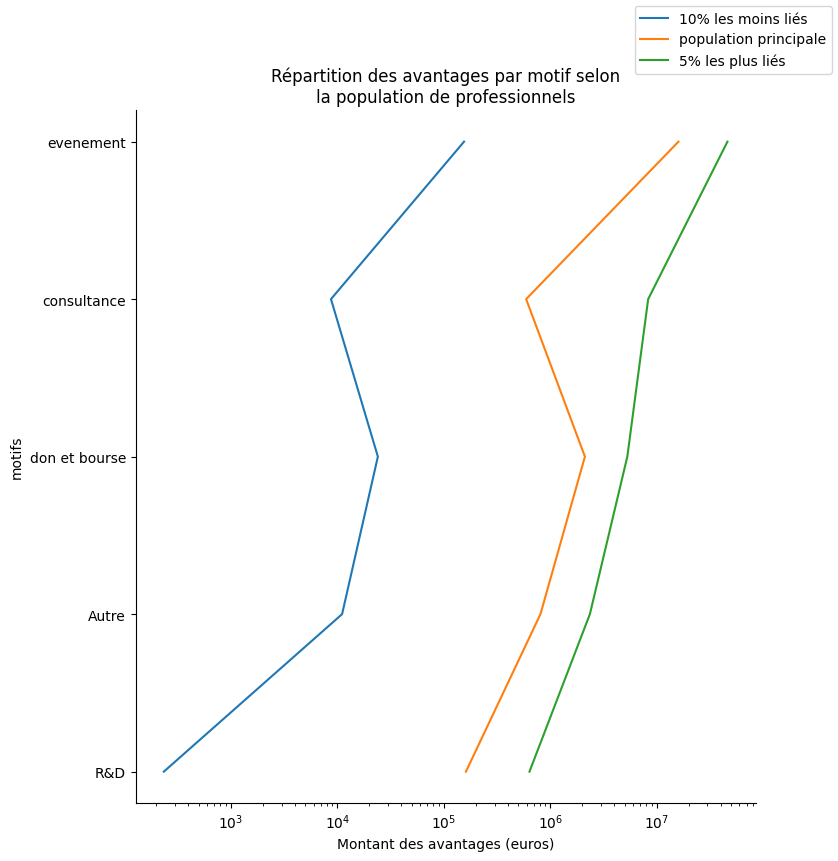

In [ ]:
fig, ax = plt.subplots(figsize=(8, 9))
for i, lab in enumerate(labels):
    id_beneficiaires = dim_beneficiaire.filter(
        (col("montant_total") > limits[i]) & (col("montant_total") <= limits[i + 1])
    )["efd_id"]

    repartition = (
        liens.filter(col("efd_id").is_in(id_beneficiaires))
        .group_by("motif")
        .agg((pl.col("montant") + (1 if i == 0 else 0)).sum())
    )
    ordered = per_motif.select("motif").join(repartition, on="motif", how="left")
    ax.plot(
        ordered["montant"],
        range(len(ordered)),
        label=lab,
    )


ax.set_yticks(range(len(per_motif)))
ax.set_yticklabels(per_motif["motif"])
ax.set_xscale("log")
ax.set_xlabel("Montant des avantages (euros)")
ax.set_ylabel("motifs")
ax.set_title(
    "Répartition des avantages par motif selon\nla population de professionnels"
)
fig.legend()
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
filters = {
    "gini faible": (col("montant_total") < 2000)
    & (col("gini") < 0.5)
    & (col("montant_total") > 20),
    "gini fort": (col("montant_total") > 500) & (col("gini") > 0.5),
}

gini faible 70800
gini fort 8429


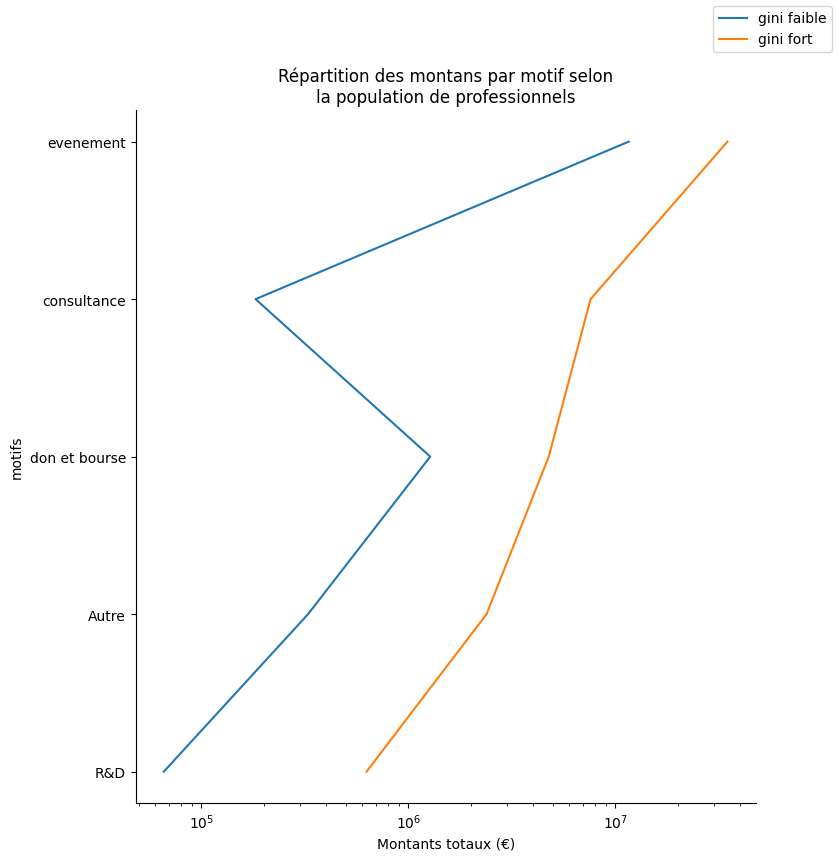

In [ ]:
fig, ax = plt.subplots(figsize=(8, 9))

motifs = list(per_motif["motif"])

for label, filt in filters.items():
    id_beneficiaires = dim_beneficiaire.filter(filt)["efd_id"]
    print(label, len(id_beneficiaires))
    ordered = [
        dim_beneficiaire.filter(col("efd_id").is_in(id_beneficiaires))
        .select(
            (col("montant_total") * col("pct_motif_" + motif.replace(" ", "_")))
            .alias("montant")
            .fill_null(0)
        )["montant"]
        .sum()
        for motif in motifs
    ]
    ax.plot(
        ordered,
        range(len(ordered)),
        label=label,
    )


ax.set_yticks(range(len(per_motif)))
ax.set_yticklabels(per_motif["motif"])
ax.set_xscale("log")
ax.set_xlabel("Montants totaux (€)")
ax.set_ylabel("motifs")
ax.set_title("Répartition des montans par motif selon\nla population de professionnels")
fig.legend()
fig.savefig("dum.png", bbox_inches="tight")

In [ ]:
motifs = sorted(liens.filter(col("montant") > 0)["motif"].unique(), reverse=True)
motifs

['evenement', 'don et bourse', 'consultance', 'R&D', 'Autre']

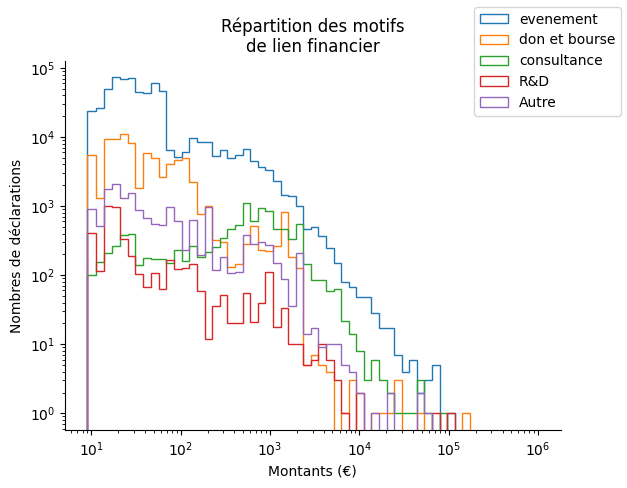

In [ ]:
fig, ax = plt.subplots()
m = np.ceil(np.log10(liens["montant"].max()))
bins = np.float_power(10, np.linspace(1, m, int(m * 10))) - 1
opts = {"histtype": "step", "bins": bins}
for mot in motifs:
    tmp = liens.filter((col("motif") == mot) & (col("montant") > 0))
    ax.hist(tmp["montant"], **opts, label=mot)
ax.set_title("Répartition des motifs\nde lien financier")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Montants (€)")
ax.set_ylabel("Nombres de déclarations")
fig.legend()
fig.savefig("dum.png", bbox_inches="tight")